<a href="https://colab.research.google.com/github/HernanJMaurice/androidSensors/blob/main/HPC/Maurice_Hernan_Ejercicio_2_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#1 Introduccion

Este ejercicio realiza una comparacion entre dos imagenes. Y muestra una imagen con todas las diferencias entre ambas. Realiza una resta entre las imagenes y marca las diferencias entre estas en una nueva.

El ruido digital es la variación aleatoria del brillo o el color en las imágenes digitales producido por la camara. Debido a ésto puede que dos fotos que hayan capturado lo mismo, se vean diferentes. Para evitar que se marquen diferencias que no existen se debe ingresar un valor (Umbral Diferencia) el cual representa el valor minimo de variacion que deben tener los pixeles para ser considerados como diferentes.

Este tipo de aplicaciones se usa en el campo Astrofotografico. La diferencia entre fotos en los astros es uno de los metodos que permite visualizar asteroides ya que eliminaria todas las estrellas que se encuentren estaticas en ambas fotos, dejando solo al/los asteroides.

Las fotos deben tener la mismas dimensiones, ya que si no no se podria comparar pixel por pixel.

#2 Armado del Ambiente

Primero instale pycuda, la biblioteca de CUDA de pyton.

Luego, cargue ambas imagenes en la seccion de parametros, ingrese el umbral de diferencia que desea y ejecute.

Para pruebas se subieron fotos al directorio Github, las mismas se pueden ver en este link:

https://github.com/HernanJMaurice/androidSensors/tree/main/HPC/imagenes

Solo deberia agregar: Nombre_de_la_imagen + ?raw=true Ejemplo: https://github.com/HernanJMaurice/androidSensors/tree/main/HPC/imagenes/image1.jpeg?raw=true

In [1]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 13.8MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=d7d2e93d4c9a4383b0184abe521714797d26dacd18a3926910dd229ba706d1e8
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=de82d33420e4a8c823380f020b1d838aa5073c21982957842219f93c681f1980
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


In [3]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_primer_imagen = "https://github.com/HernanJMaurice/androidSensors/blob/main/HPC/imagenes/image2.jpeg?raw=true" #@param {type:"string"}
url_segunda_imagen = "https://github.com/HernanJMaurice/androidSensors/blob/main/HPC/imagenes/image4.jpeg?raw=true" #@param {type:"string"}
umbral_diferencia =  20#@param {type:"number"}


#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_primer_imagen} -O imagen1.jpeg
!wget {url_segunda_imagen} -O imagen2.jpeg

--2020-11-20 23:23:30--  https://github.com/HernanJMaurice/androidSensors/blob/main/HPC/imagenes/image2.jpeg?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/HernanJMaurice/androidSensors/raw/main/HPC/imagenes/image2.jpeg [following]
--2020-11-20 23:23:30--  https://github.com/HernanJMaurice/androidSensors/raw/main/HPC/imagenes/image2.jpeg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HernanJMaurice/androidSensors/main/HPC/imagenes/image2.jpeg [following]
--2020-11-20 23:23:30--  https://raw.githubusercontent.com/HernanJMaurice/androidSensors/main/HPC/imagenes/image2.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.git

Imagen del filtro: imagen2.jpeg -RGB- [960, 1280]
Thread: [ 16 , 19  ], Bloque : [ 60 , 68 ]
Total de Thread: [ 960 , 1292  ]  =  1240320
Tiempo TOTAL:  121.187 [ms]
Tiempo GPU  :  0.09 [ms]


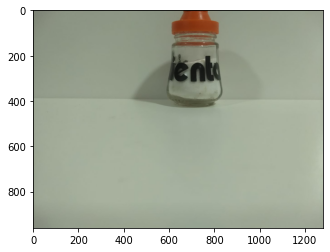

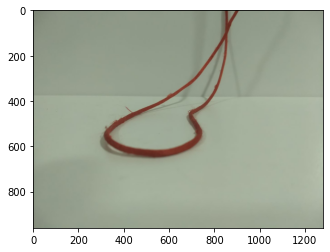

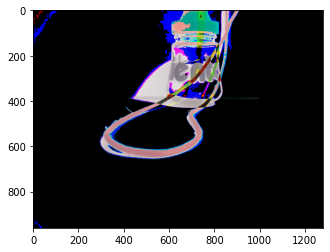

In [22]:
try: 
      %matplotlib inline
      from datetime import datetime
      tiempo_total = datetime.now()

      import matplotlib.pyplot as plt
      import numpy
      from PIL import Image 
      import pycuda.driver as cuda
      import pycuda.autoinit
      from pycuda.compiler import SourceModule

      # --------------------------------------------
      # Definición de función que transforma el tiempo en  milisegundos 
      tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
      # --------------------------------------------

      if umbral_diferencia < 0 :
            raise Exception("El campo Umbral debe ser positivo o 0.")

      #---------------------------------------------
      #           Primera Imagen
      #---------------------------------------------

      img_nombre = 'imagen1.jpeg'
      image1 = Image.open( img_nombre ) 
        
      # Optengo las proporsiones de la imagen. 
      img1_alto, img1_ancho = image1.size 

      # Convierto la imagen comprimida en JPEG/PNG a array.
      img1_origen_cpu = numpy.asarray(image1)

      # Reservo el vector en GPU
      img1_origen_gpu = cuda.mem_alloc( img1_origen_cpu.nbytes )

      #---------------------------------------------
      #           Segunda Imagen
      #---------------------------------------------

      img_nombre = 'imagen2.jpeg'
      image2 = Image.open( img_nombre ) 
        
      # Optengo las proporsiones de la imagen. 
      img2_alto, img2_ancho = image2.size 

      # Convierto la imagen comprimida en JPEG/PNG a array.
      img2_origen_cpu = numpy.asarray(image2)

      # Reservo el vector en GPU
      img2_origen_gpu = cuda.mem_alloc( img2_origen_cpu.nbytes )


      if (img2_alto != img1_alto) or (img2_ancho != img1_ancho):
            raise Exception("Las imagenes deben tener las mismas medidas.")

      #---------------------------------------------
      #           Imagen Resultado
      #---------------------------------------------

      #Creo un array vacio
      img_resultado_cpu = numpy.empty_like( img1_origen_cpu )

      img_resultado_gpu = cuda.mem_alloc( img_resultado_cpu.nbytes )


      # GPU - Copio la memoria al GPU.
      cuda.memcpy_htod( img1_origen_gpu, img1_origen_cpu )
      cuda.memcpy_htod( img2_origen_gpu, img2_origen_cpu )
      cuda.memcpy_htod( img_resultado_gpu, img_resultado_cpu )

      # CPU - Defino la función kernel que ejecutará en GPU.
      module = SourceModule("""
      __global__ void kernel_img( int ancho, int alto, int umbral_diferencia, char *img_o, char *img2_o, char *img_R )
      {
        // Calculo las coordenadas del Thread en dos dimensiones.
        int idx = threadIdx.x + blockIdx.x*blockDim.x;
        int idy = threadIdx.y + blockIdx.y*blockDim.y;
        float px1_r, px2_r, px1_g, px2_g, px1_b, px2_b, pr, pb , pg;

        // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
        if( idx < ancho && idy < alto )
        {
            px1_r = (float) img_o[(idx+(idy*ancho))*3    ];
            px2_r = (float) img2_o[(idx+(idy*ancho))*3    ];

            px1_g = (float) img_o[((idx+(idy*ancho))*3)+1];
            px2_g = (float) img2_o[((idx+(idy*ancho))*3)+1];

            px1_b = (float) img_o[((idx+(idy*ancho))*3)+2];
            px2_b = (float) img2_o[((idx+(idy*ancho))*3)+2];


            if ( px2_r > px1_r)
            {
              pr = px2_r - px1_r;
            }else
            {
              pr = px1_r - px2_r;
            } 


            if ( px2_g > px1_g)
            {
              pg = px2_g - px1_g;
            }else
            {
              pg = px1_g - px2_g;
            } 


            if ( px2_b > px1_b)
            {
              pb = px2_b - px1_b;
            }else
            {
              pb = px1_b - px2_b;
            } 
            

            if(pr < umbral_diferencia)
            {
              pr = 0;
            }

            if(pg < umbral_diferencia)
            {
              pg = 0;
            }

            if(pb < umbral_diferencia)
            {
              pb = 0;
            }

            // Escribo el color del pixel.
            img_R[(idx+(idy*ancho))*3  ] = (char) pr;
            img_R[((idx+(idy*ancho))*3)+1] = (char) pg;
            img_R[((idx+(idy*ancho))*3)+2] = (char) pb;
        }
      }
      """) 


      # Muestro los atributos de la imagen y como se ve antes del seudo filtro.
      print("Imagen del filtro: " + img_nombre + " -" + image1.mode + "- [" + str(img1_ancho) + ", " + str(img1_alto ) + "]" )  

      # CPU - Genero la función kernel.
      kernel = module.get_function("kernel_img")

      tiempo_img = datetime.now()

      dim_hilo_x = 16
      dim_bloque_x = numpy.int( (img1_ancho+dim_hilo_x-1) / dim_hilo_x )

      dim_hilo_y = 19
      dim_bloque_y = numpy.int( (img1_alto+dim_hilo_y-1) / dim_hilo_y )

      print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
      print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

      tiempo_img = datetime.now()

      kernel( numpy.int32(img1_ancho), numpy.int32(img1_alto), numpy.int32(umbral_diferencia), img1_origen_gpu, img2_origen_gpu, img_resultado_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

      tiempo_img = datetime.now() - tiempo_img

      # GPU - Copio el resultado desde la memoria GPU.
      cuda.memcpy_dtoh( img_resultado_cpu, img_resultado_gpu )

      # Muestro la imagen Original el filtro.
      plt.figure()
      imgplot=plt.imshow( img1_origen_cpu )

      # Muestro la imagen Original el filtro.
      plt.figure()
      imgplot=plt.imshow( img2_origen_cpu )


      # Muestro la imagen luego de aplicarle el filtro.
      plt.figure()
      imgplot=plt.imshow( img_resultado_cpu )

      tiempo_total = datetime.now() - tiempo_total

      print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
      print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

except ModuleNotFoundError:
    print( "ERROR: Instale el modulo de CUDA de Python." )
except FileNotFoundError:
    print('ERROR: Por favor importe las imagenes a comparar.')
except NameError:
    print('ERROR: Por favor ingrese un Umbral como parametro.') 
except Exception as e:
    print('ERROR: ' ,e.args)   

# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  wget url_imagen       | Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline    | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el còdigo del kernel.
CPU      |  module.get_function() | convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  print()               | Informa los atributos de la imagen.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.




# 5 Conclusiones

La diferencia entre imagenes para mostrar las variaciones se realiza comparando cada color de pixel por cada color del mismo pixel de la otra imagen. Se puede imaginar el acceso a cada pixel como una matriz. Cada imagen tiene un ancho(x) y un alto (y) para acceder a cada pixel se recorre cada "Fila y columna" (de pixeles) que posee la imagen. En este caso se utiliza la GPU, la cual permite que ejecutemos el algoritmo de procesamiento en diferetes hilos, disminuyendo la complejidad del algoritmo cuando se ejecuta en CPU N(O^2) con lo cual permite una ejecucion mucho mas rapida.

La comparacion se realiza restando ambos pixeles, si en ambos pixeles no hubo cambio la esta daria 0. Como las camaras fotograficas introducen un ruido en la imagen, aunque lo capturado sea exactamente igual puede que la resta no de 0. Por lo que luego de la resta se compara el resultado con el umbral ingresado y en caso de ser menor, se lo toma como si la resta hubiese dado 0, si da mayor al umbral, se lo toma como que hay una diferencia.

Se realizaron 16 ejecuciones de este algoritmo y se consiguio un promedio de tiempo de ejecucion del algoritmo de procesamiento de las imagenes de 0,096 MS. Cuyos tiempos oscilan entre 0,079 MS y 0,136 MS.

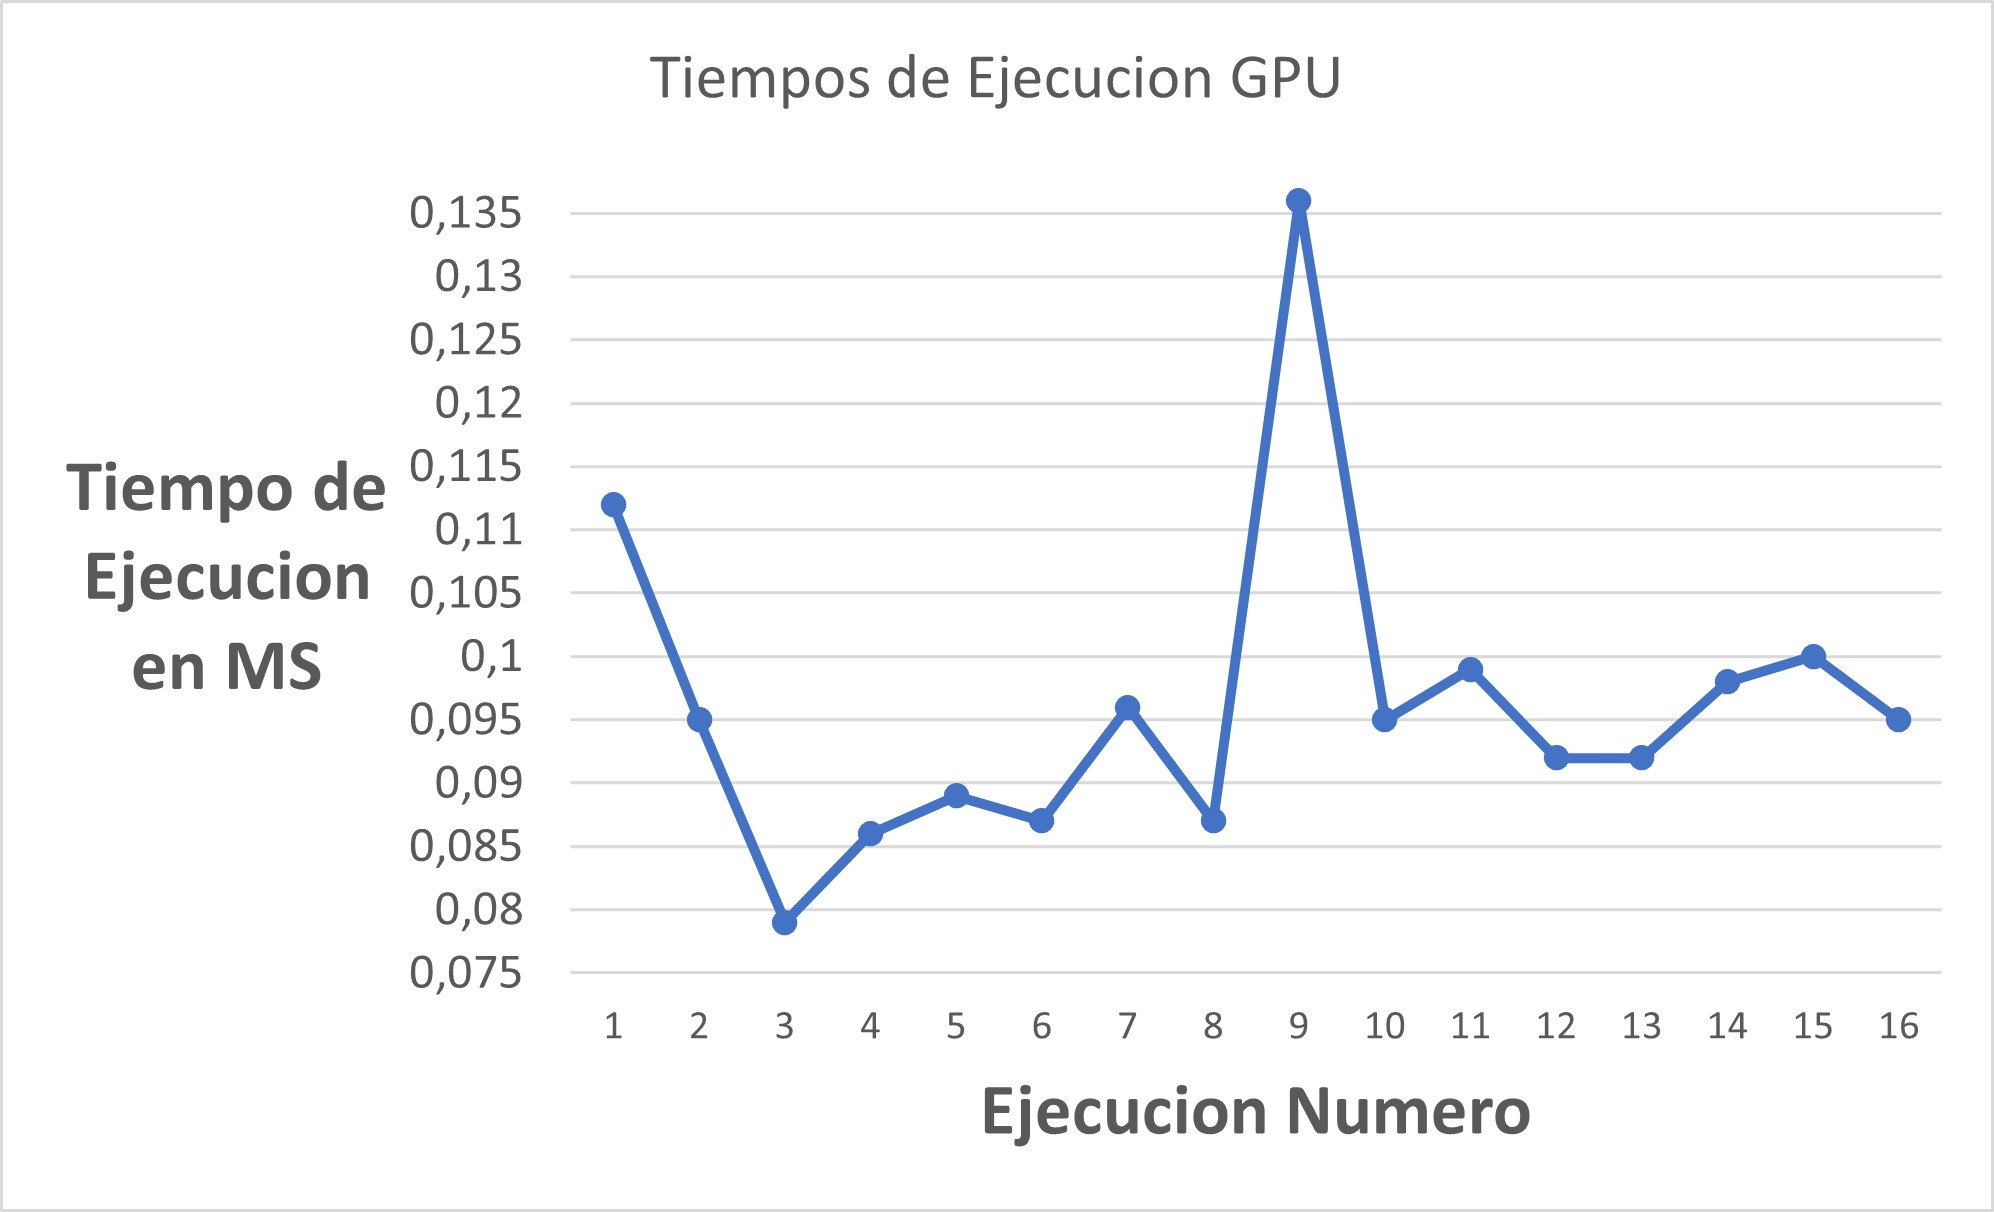

Como vemos, gracias a la ejecucion en diferenes Threads, podemos realizar el procesamiento de imagenes mucho mas rapido, lo cual nos facilita el procesado de imagenes en cantidad. A su vez permitiria poder someter a otros tipos de filtros a las imagenes en el tiempo en que se procesaba con la CPU un solo par de imagenes.